# **K-Means**

Silhouette Scores:
K=2: 0.302
K=3: 0.256
K=4: 0.236
K=5: 0.224
K=6: 0.209


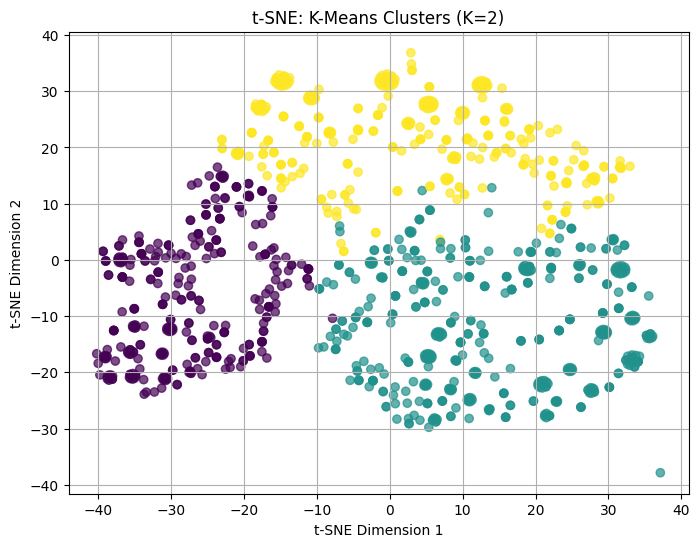


Cluster Summary (Label-Encoded Averages):
         care_options  benefits  coworkers  supervisor  family_history  \
Cluster                                                                  
0            0.889231  1.024615   0.984615    1.153846        0.335385   
1            0.293501  0.568134   0.968553    1.027254        0.354298   
2            1.819407  1.703504   0.994609    1.150943        0.509434   

         treatment  work_interfere  
Cluster                             
0         0.424615        0.403077  
1         0.412998        3.238994  
2         0.687332        2.927224  


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('Survey Reprised 2.0.csv')

# Step 1: Filter ages between 21 and 45
df_filtered = df[(df['Age'] >= 21) & (df['Age'] <= 45)]

# Step 2: Select relevant features
features = [
    'care_options',       # Perceived mental health support
    'benefits',
    'coworkers',          # Openness to discussing mental health
    'supervisor',
    'family_history',     # Prior experience with mental health issues
    'treatment',
    'work_interfere'
]
df_cluster = df_filtered[features].copy()

# Step 3: Encode categorical features
label_encoders = {}
for col in df_cluster.columns:
    le = LabelEncoder()
    df_cluster[col] = le.fit_transform(df_cluster[col].astype(str))
    label_encoders[col] = le

# Step 4: Evaluate silhouette scores for K = 2 to 6
silhouette_scores = {}
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_cluster)
    score = silhouette_score(df_cluster, labels)
    silhouette_scores[k] = score

# Print silhouette scores
print("Silhouette Scores:")
for k, score in silhouette_scores.items():
    print(f"K={k}: {score:.3f}")

# Step 5: Final KMeans with best K (K=2)
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cluster['Cluster'] = kmeans_final.fit_predict(df_cluster)

# Step 7: t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_components = tsne.fit_transform(df_cluster.drop(columns='Cluster'))

plt.figure(figsize=(8, 6))
plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c=df_cluster['Cluster'], alpha=0.7)
plt.title('t-SNE: K-Means Clusters (K=2)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()

# Step 8: Cluster interpretation
cluster_summary = df_cluster.groupby('Cluster').mean()
print("\nCluster Summary (Label-Encoded Averages):")
print(cluster_summary)


* **Interpretation**

| Cluster | Description                      | Traits                                                                             |
| ------- | -------------------------------- | ---------------------------------------------------------------------------------- |
| 0       | **Low Need / Low Awareness**     | Low on all features. No treatment, little interference, limited support awareness. |
| 1       | **Moderate Risk / Low Openness** | Has family history or some work interference, but low comfort discussing issues.   |
| 2       | **High Need / High Openness**    | High treatment, family history, openness to discuss, and awareness of support.     |


# **DBScan**

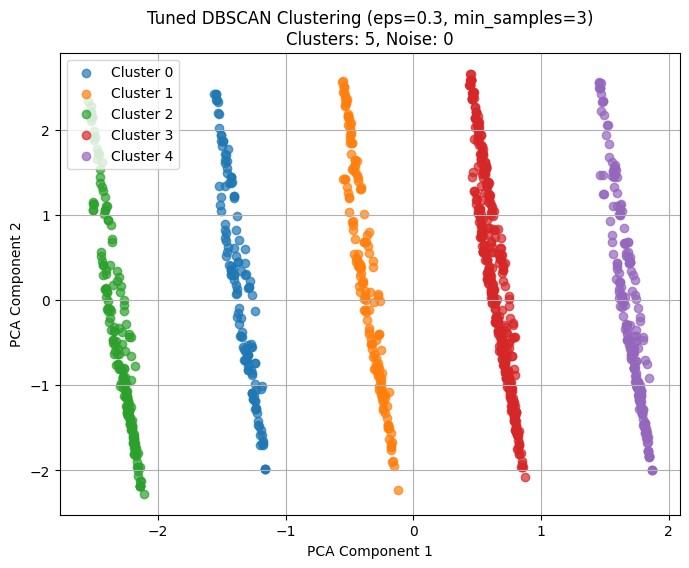

Evaluation Metrics (excluding noise):
Silhouette Score: 0.227
Davies-Bouldin Index: 1.986
Calinski-Harabasz Index: 407.482


In [10]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# Step 1: Load the dataset
df = pd.read_csv("Survey Reprised 2.0.csv")

# Step 2: Select relevant mental health features
features = [
    'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity',
    'coworkers', 'supervisor', 'mental_health_interview',
    'family_history', 'treatment', 'work_interfere'
]
df_selected = df[features].copy()

# Step 3: Encode categorical features
encoder = OrdinalEncoder()
encoded_data = encoder.fit_transform(df_selected)

# Step 4: Apply PCA to reduce dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(encoded_data)

# Step 5: Standardize PCA-reduced data for DBSCAN
scaler = StandardScaler()
scaled_data = scaler.fit_transform(reduced_data)

# Step 6: Apply DBSCAN with tuned parameters
dbscan_model = DBSCAN(eps=0.3, min_samples=3)
dbscan_labels = dbscan_model.fit_predict(scaled_data)

# Step 7: Count number of clusters and noise points
num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
num_noise = list(dbscan_labels).count(-1)

# Step 8: Visualize DBSCAN clustering
plt.figure(figsize=(8, 6))
for label in set(dbscan_labels):
    label_mask = dbscan_labels == label
    plt.scatter(
        reduced_data[label_mask, 0],
        reduced_data[label_mask, 1],
        label=f'Cluster {label}' if label != -1 else 'Noise',
        alpha=0.7
    )
plt.title(f'Tuned DBSCAN Clustering (eps=0.3, min_samples=3)\nClusters: {num_clusters}, Noise: {num_noise}')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

# Step 9: Evaluate DBSCAN performance (excluding noise)
mask = dbscan_labels != -1
filtered_data = reduced_data[mask]
filtered_labels = dbscan_labels[mask]

if len(set(filtered_labels)) > 1:
    silhouette = silhouette_score(filtered_data, filtered_labels)
    davies_bouldin = davies_bouldin_score(filtered_data, filtered_labels)
    calinski_harabasz = calinski_harabasz_score(filtered_data, filtered_labels)

    print("Evaluation Metrics (excluding noise):")
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")
else:
    print("Not enough clusters to evaluate.")

# Step 10: Profile clusters (excluding noise)
encoded_df = pd.DataFrame(encoded_data, columns=features)
encoded_df['dbscan_cluster'] = dbscan_labels

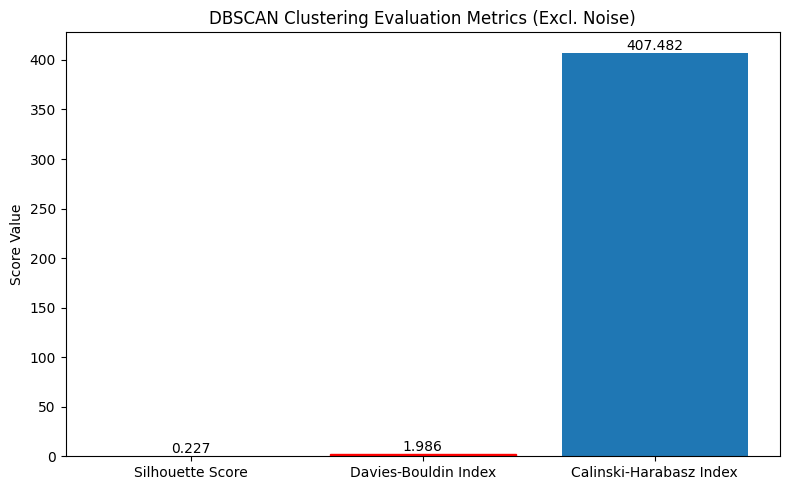

In [11]:
# Step 11: Visualize evaluation metrics (if available)
if len(set(filtered_labels)) > 1:
    metrics = {
        "Silhouette Score": silhouette,
        "Davies-Bouldin Index": davies_bouldin,
        "Calinski-Harabasz Index": calinski_harabasz
    }

    plt.figure(figsize=(8, 5))
    bars = plt.bar(metrics.keys(), metrics.values())
    
    # Invert Davies-Bouldin bar for visual comparison (optional)
    bars[1].set_color('red')  # Highlight Davies-Bouldin as it's minimized

    # Annotate values on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', ha='center', va='bottom')

    plt.title("DBSCAN Clustering Evaluation Metrics (Excl. Noise)")
    plt.ylabel("Score Value")
    plt.tight_layout()
    plt.show()


# **Agglomerative**

Silhouette Scores for Agglomerative Clustering:
K=2: 0.279
K=3: 0.222
K=4: 0.200
K=5: 0.185
K=6: 0.182


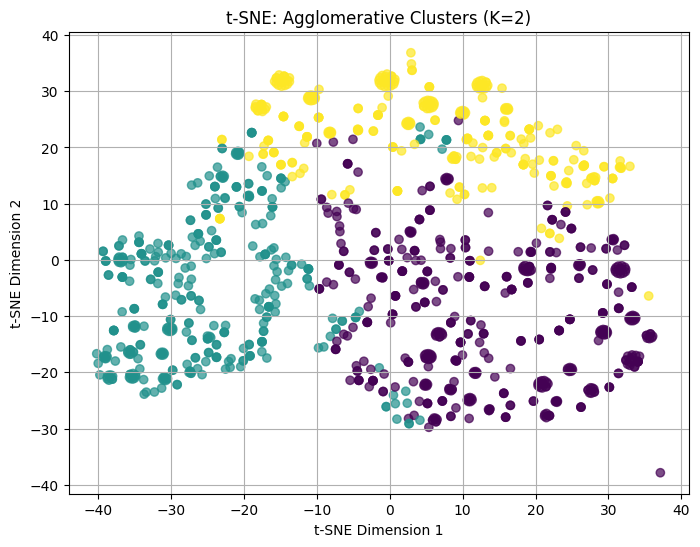


Cluster Feature Averages (Label-Encoded):
         care_options  benefits  coworkers  supervisor  family_history  \
Cluster                                                                  
0               0.349     0.653      1.004       1.082           0.367   
1               0.919     1.056      0.946       1.116           0.360   
2               1.900     1.682      0.987       1.116           0.492   

         treatment  work_interfere  
Cluster                             
0            0.429           3.261  
1            0.473           0.616  
2            0.656           3.006  


In [12]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("Survey Reprised 2.0.csv")  # Adjust path if needed

df_filtered = df[(df['Age'] >= 21) & (df['Age'] <= 45)]

features = [
    'care_options',       # Perceived mental health support
    'benefits',
    'coworkers',          # Openness to discussing mental health
    'supervisor',
    'family_history',     # Prior experience with mental health issues
    'treatment',
    'work_interfere'
]
df_cluster = df_filtered[features].copy()

label_encoders = {}
for col in df_cluster.columns:
    le = LabelEncoder()
    df_cluster[col] = le.fit_transform(df_cluster[col].astype(str))
    label_encoders[col] = le

print("Silhouette Scores for Agglomerative Clustering:")
for k in range(2, 7):
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(df_cluster)
    score = silhouette_score(df_cluster, labels)
    print(f"K={k}: {score:.3f}")

agglo = AgglomerativeClustering(n_clusters=3)
df_cluster['Cluster'] = agglo.fit_predict(df_cluster)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_components = tsne.fit_transform(df_cluster.drop(columns='Cluster'))

plt.figure(figsize=(8, 6))
plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c=df_cluster['Cluster'], alpha=0.7)
plt.title('t-SNE: Agglomerative Clusters (K=2)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()

print("\nCluster Feature Averages (Label-Encoded):")
print(df_cluster.groupby('Cluster').mean().round(3))

* **Interpretation**

| Cluster | Persona Name                     | Traits Summary                                                                                           | Suggested Action                                                                  |
| ------- | -------------------------------- | -------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------- |
| **0**   | 🟢 Low-Need / Low-Awareness      | - Rarely reports mental health interference<br>- Low treatment and family history<br>- Low openness      | Mental health education, reduce stigma, raise awareness                           |
| **1**   | 🟡 Moderate-Risk / Under-Engaged | - Some interference and family history<br>- Unlikely to seek treatment<br>- Limited workplace engagement | Provide anonymous resources, encourage safe disclosure, peer support              |
| **2**   | 🔴 High-Need / Highly Engaged    | - High family history and treatment<br>- Frequently reports interference<br>- Open to discussing issues  | Ensure access to professional support, therapy, leave policies, wellness programs |
